# Monte Carlo Simulation of Nuclear Decay
## Oliver Chapman
### 01/05/2018

This script models a nuclear physics experiment:
 - A beam of unstable nuclei travels in the z direction at 2000 m/s,
 - The nuclei decay with a mean lifetime of 520 $ \mu s$ producing a gamma ray,
 - The nuclei are emitted isotropically in a spherical distribution.
 
A detector array of 2 x 2 m is set up perpendicular to the beam 2 m from the injection point with a resolution of 10 cm in x and 30 cm in y.

<p><img src="https://raw.githubusercontent.com/ochapman-code/montecarlo/master/diagram.png" width="50%" > </p>

This simulation calculates the distribution of gamma rays detected in the experiment using multiple Monte Carlo samples and applies a Gaussian smearing to the resulting output at the detector.

Spherical coordinates are defined using the standard mathematical conventions. These are depicted well on wikipedia:

<p><a href="https://commons.wikimedia.org/wiki/File:3D_Spherical_2.svg#/media/File:3D_Spherical_2.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/d/dc/3D_Spherical_2.svg" alt="3D Spherical 2.svg" width="33%" ></a><br>By &lt;a href="//commons.wikimedia.org/wiki/User:Dmcq" title="User:Dmcq"&gt;Dmcq&lt;/a&gt; - &lt;span class="int-own-work" lang="en"&gt;Own work&lt;/span&gt;, <a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=18913446">Link</a></p>

### 1) Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define variables for graph legends
r = mpatches.Patch(color='r', label='reject')
g = mpatches.Patch(color='g', label='accept')

### 2) Define a uniform distribition function

In [2]:
# This function creates a uniform random distribution between a and b
def rand(a, b):
        return (b-a) * np.random.random() + a

### 3) Monte Carlo

To calculate the expected distribution on the detector array, we will split the task into 3 steps:
1. Position of decay:
  - Nuclear decay is modelled by an exponential decay distribution. The decay can be detected if it occurs at $d_z<2$m.
2. Direction of decay:
  - The emitted gamma ray is emitted isotropically in any direction. This is calculatd by randomly picking a point by taking uniform variables $\mathcal{U}$ and $\mathcal{V}$ on (0,1) to give $\theta = 2 \pi u$ and $\phi = 2 \cos ^{-1} (2v -1)$.
3. Collision with detector:
  - If the gamma ray collides with the detector the sample is recorded. This is calculated using simple geometry.

In [3]:
# Run Monte Carlo simulation with N samples

N = 100000      # The number of Monte Carlo samples run
w, h = 2, 2    # The height and width of the detector
delta = 1.04   # The decay constant for the radioactive decay
arr_d = []
arr_phi_a = []; arr_theta_a = [] # Accepted in step 2
arr_phi_r = []; arr_theta_r = [] # Rejected in step 2
x_a = []; y_a = [] # Accepted in step 3
x_r = []; y_r = [] # Rejected in step 3

for n in range(N):
    
    # Step 1:
    # - Randomly calculate the distance where decay occurs releasing a gamma particle (photon)
    d_z = -delta * np.log(1 - rand(0, 1))
    arr_d.append(d_z)
    
    # - The sample is rejected if the decay occurs after reaching the detector (at 2m)
    if d_z >= 2:
        continue
    
    # Step 2:
    # - Randomly generate the spherical direction of gamma particle emission (see diagram above)
    phi = np.arccos(rand(-1, 1))      # Generates sinusoidal distribution between 0 and pi - see graph below
    theta = rand(0, 1) * 2 * np.pi    # Generates a uniform distribution between 0 and 2 pi
    
    # - Select only particles travelling forwards towards the detector (i.e. in upper hemisphere)
    # - Reject if travelling away from the detector
    if phi >= np.pi / 2:
        arr_phi_r.append(phi); arr_theta_r.append(theta)
        continue
    
    arr_phi_a.append(phi); arr_theta_a.append(theta)
    
    # Step 3:
    # - Calculate the distance to the detector in x, y, and z directions from decay position
    p_z = 2 - d_z
    p = p_z / np.cos(phi)
    p_x = p * np.sin(phi) * np.cos(theta)
    p_y = p * np.sin(phi) * np.sin(theta)

    # Store the position when particles collide with the detector
    if (abs(p_x) < w / 2) and (abs(p_y) < h / 2):
        x_a.append(p_x); y_a.append(p_y)
    else:
        x_r.append(p_x); y_r.append(p_y)

Now let's look at the results from the Monte Carlo simulation steps in more detail...

#### 3.1) Exponential decay

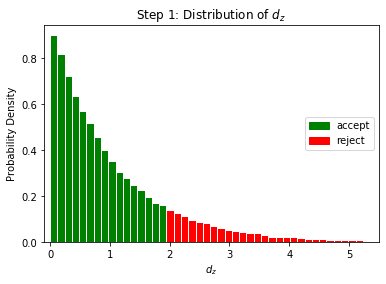

In [4]:
n, bins, patches = plt.hist(arr_d, density=True, bins=100, edgecolor='w')

for i, j in enumerate(bins[1:]):
    col = 'g' if j <= 2 else 'r'
    patches[i].set_facecolor(col)
    
plt.xlim(-0.1, 5.5)
plt.xlabel('$d_z$'); plt.ylabel('Probability Density')
plt.legend(handles=[g, r], loc='center right')
plt.title("Step 1: Distribution of $d_z$");

#### 3.2) Picking points on the sphere - forwards or backwards?

The graph below shows that the random variable $\varphi$ has a sinusoidal distribution. This is required to randomly pick points on the sphere.
Wolfram has a good resource to understand this in more detail https://mathworld.wolfram.com/SpherePointPicking.html.

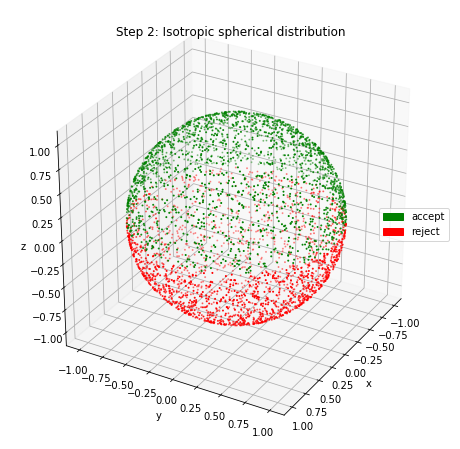

In [5]:
from mpl_toolkits import mplot3d
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.view_init(30, 30)

colours = ['g', 'r']
arr_phi = [arr_phi_a, arr_phi_r]
arr_theta = [arr_theta_a, arr_theta_r]

for i in [0,1]:
    sample_phi = arr_phi[i][:2000]
    sample_theta = arr_theta[i][:2000]
    s_x = np.sin(sample_phi)*np.cos(sample_theta)
    s_y = np.sin(sample_phi)*np.sin(sample_theta)
    s_z = np.cos(sample_phi)
    ax.scatter3D(s_x, s_y, s_z, c=colours[i], s=1)

ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
plt.legend(handles=[g, r], loc='center right')
plt.title("Step 2: Isotropic spherical distribution");

#### 3.3) Detecting collisions with the detector

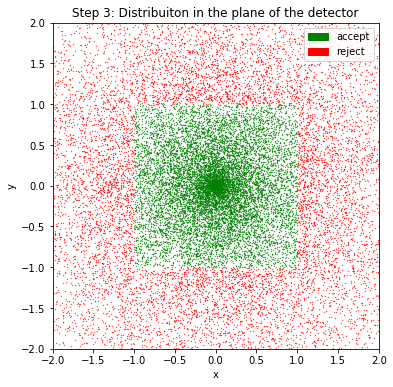

In [6]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

arr_x = [x_a, x_r]
arr_y = [y_a, y_r]
colours = ['g', 'r']

for i in [0,1]:
    sample_x = arr_x[i]; sample_y = arr_y[i]
    plt.scatter(sample_x, sample_y, c=colours[i], s=.1)

plt.xlabel('x'); plt.ylabel('y')
plt.xlim(-w,w);  plt.ylim(-h,h)
plt.legend(handles=[g, r], loc='upper right')

plt.title("Step 3: Distribuiton in the plane of the detector");

#### 3.4) Summary of Section 3

In [7]:
print(N, "Monte Carlo samples run:")
print("Step 1:", len([d for d in arr_d if d < 2]), "samples decay when d_z < 2")
print("Step 2:", len(arr_phi_a), "samples decay forwards towards the detector with phi < pi/2")
print("Step 3:", len(x_a), "samples collide with (and are recorded by) the detector")

100000 Monte Carlo samples run:
Step 1: 85373 samples decay when d_z < 2
Step 2: 42487 samples decay forwards towards the detector with phi < pi/2
Step 3: 12465 samples collide with (and are recorded by) the detector


### 4) Apply Gaussian Smearing

In [8]:
ld = 100

# Create a meshgrid to represent the detector
X = np.arange(-w/2, w/2, 1/ld)
Y = np.arange(-h/2, h/2, 1/ld)
xx, yy = np.meshgrid(X, Y, sparse=True)

# Detector resoultion in x and y
sd_x, sd_y = 0.1, 0.3

# The distribution of gamma rays on the detector is given by Z
Z = np.zeros([len(Y), len(X)])

for i in range(len(x_a)):
    
    # Calculate the components of a 2D Gaussian
    x_comp = (xx - x_a[i]) ** 2 / (2 * sd_x ** 2)
    y_comp = (yy - y_a[i]) ** 2 / (2 * sd_y ** 2)
    
    # Add the contribution of each collision from the Monte Carlo simulation
    Z += np.exp(- x_comp - y_comp)  

# Normalise the result
Z = Z / ((2 * np.pi * sd_x * sd_y) * len(x_a))

### 5) Plot the results

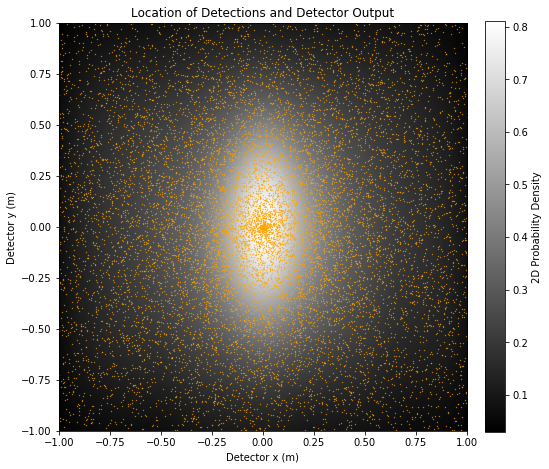

In [9]:
plt.figure(figsize=(8, 8))

plt.imshow(Z, origin='lower', extent=[-w/2,w/2,-h/2,h/2], cmap=plt.get_cmap("gist_gray"), label='Detector signal')
plt.colorbar(fraction=0.046, pad=0.04, label="2D Probability Density")
plt.scatter(x_a,y_a, s=.1, color='orange', label='collisions')

plt.xlim(xmin=-w/2, xmax=w/2); plt.ylim(ymin=-h/2, ymax=h/2)
plt.xlabel("Detector x (m)"); plt.ylabel("Detector y (m)")
plt.title("Location of Detections and Detector Output");